In [2]:
%pylab inline
import pandas as pd
from hscictools import bnf,ccg,gbq # my local stuff

Populating the interactive namespace from numpy and matplotlib


# Chemical cost structure of the BNF chapters

This notebook looks at spend on each BNF chapter and gauges the "complexity" of the cost structure of each chapter through principal component analysis (PCA).

For each chapter, I first compute the fractional cost of each chemical for each CCG. Then I apply PCA to each chapter and plot explained variance versus number of principal chemical components. The fewer components needed to explain a good fraction of the variance, the simpler the cost structure of the chapter.

The next step would be to look at the principal chemical components themselves for each chapter since these are the features aligned with the variation in each chapter. I give a quick illustration of this.


## BigQuery

For this analysis, we need costs for each (chemical, CCG) pair: quite a large result set.

In [4]:
df=gbq.query(
    '''
    select BNF_CHEMICAL,PCT,sum(ACT_COST) TOTAL_ACT_COST
    from [nhs.PDPI2]
    where PERIOD contains "2015"
    group by BNF_CHEMICAL, PCT
    ''',
    max_rows=500000,
    index=['BNF_CHEMICAL','PCT'],cast={'TOTAL_ACT_COST':float},
    cachedir='/tmp/gbq'
)

Reading cached results from /tmp/gbq/42c0b627b5d645728652864c4610f7cf.json
375817 rows converted to DataFrame in 1.12 seconds


In [5]:
df.head()

,,TOTAL_ACT_COST
BNF_CHEMICAL,PCT,
1310012F0,10V,5296.77
1310020A0,10V,4703.82
210109005,10V,15729.46
225010050,10V,50380.00
0107020J0,10V,15981.07


## CCG segmentation

Again the CCGs form two clusters. Let's keep only the cluster of CCGs prescribing the broader set of chemicals.

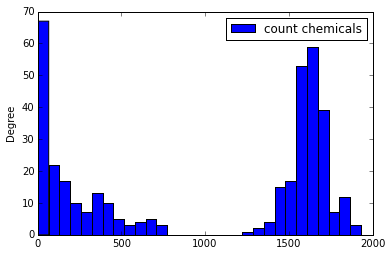

In [94]:
df.groupby(level=1).count().rename(columns={'TOTAL_ACT_COST':'count chemicals'}).plot(kind='hist',bins=30)

In [7]:
chemsperccg=df.groupby(level=1).count()
chemsperccg
ccgskeep=set(chemsperccg[chemsperccg['TOTAL_ACT_COST']>1000].index)
len(ccgskeep)

212

Let's apply this restriction to the main dataframe and map the CCG ids to names for readability.

In [151]:
dfkeep=df[df.index.map(lambda i:i[1] in ccgskeep and i[1] in ccg.ccgs())]
print "(chemical,ccg pairs) remaining:",len(dfkeep)
dfkeep.head()

(chemical,ccg pairs) remaining: 343942


,,TOTAL_ACT_COST
BNF_CHEMICAL,PCT,
1310012F0,10V,5296.77
1310020A0,10V,4703.82
210109005,10V,15729.46
225010050,10V,50380.00
0107020J0,10V,15981.07


## CCG-chapter level aggregation

Let's compute the fractional cost of each chemical inside a (CCG,chapter) pair.

First, let's add the chapters into the dataframes index (as first 2 chars of BNF chemical code).

While we're at it, let's also decode the CCG ids to names.

In [152]:
dfkeep.index=pd.MultiIndex.from_tuples(dfkeep.index.map(lambda i: (i[0],
                                                                   "%s (%s)" % (bnf.description(i[0][:2]),i[0][:2]),
                                                                   ccg.name(i[1])
                                                                  )))
dfkeep.index.set_names(['BNF_CHEMICAL','BNF_CHAPTER','CCG'],inplace=True)
dfkeep.head()

,,,TOTAL_ACT_COST
BNF_CHEMICAL,BNF_CHAPTER,CCG,
1310012F0,Skin (13),NHS SOUTH EASTERN HAMPSHIRE CCG,5296.77
1310020A0,Skin (13),NHS SOUTH EASTERN HAMPSHIRE CCG,4703.82
210109005,Appliances (21),NHS SOUTH EASTERN HAMPSHIRE CCG,15729.46
225010050,Incontinence Appliances (22),NHS SOUTH EASTERN HAMPSHIRE CCG,50380.00
0107020J0,Gastro-Intestinal System (01),NHS SOUTH EASTERN HAMPSHIRE CCG,15981.07


### Some chapters are too thin for this analysis

It's worth checking to see how many distinct chemicals are described from each chapter.

,count chemicals
BNF_CHAPTER,
Preparations used in Diagnosis (18),1
Other Drugs And Preparations (19),24
Anaesthesia (15),25
Immunological Products & Vaccines (14),29
"Obstetrics,Gynae+Urinary Tract Disorders (07)",67
Malignant Disease & Immunosuppression (08),72
"Ear, Nose And Oropharynx (12)",76
Musculoskeletal & Joint Diseases (10),85
Respiratory System (03),91


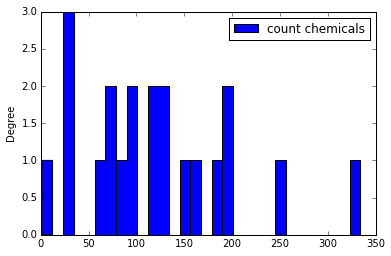

In [153]:
chemicalsperchapter=dfkeep.groupby(level=[0,1]).sum().groupby(level=1).count().rename(columns={'TOTAL_ACT_COST':'count chemicals'})
display(chemicalsperchapter.sort(columns=['count chemicals']))
chemicalsperchapter.plot(kind='hist',bins=30)

Some chapters have a tiny number of chemicals being prescribed so let's exclude them, and take only those with more than 30.

In [154]:
broadchapters=set(chemicalsperchapter[chemicalsperchapter['count chemicals']>30].index)
dfkeep2=dfkeep[dfkeep.index.map(lambda i: i[1] in broadchapters)]
# I had to rebuild index here; otherwise it was keeping hold of unwanted entries (index entries with no rows). Not sure why...
# Independently noted here: http://stackoverflow.com/questions/30941425/updating-pandas-multiindex-after-indexing-the-dataframe
dfkeep2=dfkeep2.reset_index().set_index(['BNF_CHEMICAL','BNF_CHAPTER','CCG'])

### Actually compute the fractions

This is a one-liner using pandas (though not the most obvious...)

In [158]:
# need to work around pandas limitation for joining across multiple index columns
fracs=dfkeep2.unstack(0).div(dfkeep2.groupby(level=[1,2]).sum().squeeze(),axis=0).stack()
fracs.columns=['FRAC_CCG_CHAPTER_COST']
fracs.index=fracs.index.swaplevel(1,2)
fracs.head()

FRAC_CCG_CHAPTER_COST
BNF_CHAPTER     BNF_CHEMICAL CCG                                                           
Appliances (21) 210101001    NHS AIREDALE, WHARFEDALE AND CRAVEN CCG           9.321916e-06
                210102201    NHS AIREDALE, WHARFEDALE AND CRAVEN CCG           5.860607e-05
                210102301    NHS AIREDALE, WHARFEDALE AND CRAVEN CCG           3.571778e-02
                210106001    NHS AIREDALE, WHARFEDALE AND CRAVEN CCG           5.317871e-07
                210109004    NHS AIREDALE, WHARFEDALE AND CRAVEN CCG           9.689036e-03

## Explained variance analysis

Now we have the fractions on our well behaved domain of CCGs and chapters, we can do the PCA.

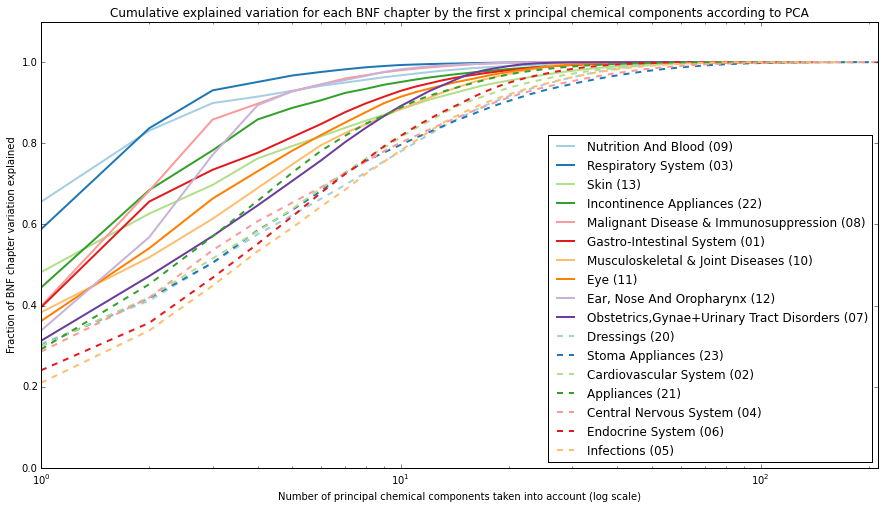

In [159]:
from sklearn.decomposition import PCA
evrlist=list() # list to hold a data frame for each chapter, which will then get concatanated to produce single dataframe of the final results
for chapter in fracs.index.levels[0]:
    crosstab=fracs.ix[chapter].unstack(0).fillna(0)
    pca=PCA()
    pca.fit_transform(crosstab)
    chapter_evr=pd.DataFrame(pca.explained_variance_ratio_,columns=['EVR'])
    chapter_evr.index=chapter_evr.index.map(lambda i:i+1)
    evrlist.append(chapter_evr)
    
evr=pd.concat(evrlist,keys=fracs.index.levels[0])
evr.index=evr.index.swaplevel(0,1) # makes it easier to find variance explained by more significant component
colors='#a6cee3,#1f78b4,#b2df8a,#33a02c,#fb9a99,#e31a1c,#fdbf6f,#ff7f00,#cab2d6,#6a3d9a'.split(',')
style=['-']*len(colors)+['--']*len(colors)
evr_unstacked=evr.unstack(1)['EVR'][evr.ix[1].sort(columns='EVR',ascending=False).index].cumsum()
ax=evr_unstacked.plot(logx=True,figsize=(15,8),linewidth=2,color=colors,style=style,ylim=0,
                      title='Cumulative explained variation for each BNF chapter by the first x principal chemical components according to PCA')
ax.set_xlabel("Number of principal chemical components taken into account (log scale)")
ax.set_ylabel("Fraction of BNF chapter variation explained")

## Principal component composition

Let's take two of the chapters and look at their principal components.


### BNF Nutrition and Blood (09)

This is the chapter whose explained variance is highest for the first principal component.

This function describes the first few components, by giving the weights for the constituent chemicals. I'll only print weights whose abs value > 0.1

In [214]:
def describe_principal_components(ch,n=5):
    crosstab=fracs.ix["%s (%s)" % (bnf.description(ch),ch)].unstack(0).fillna(0)
    pca=PCA()
    pca.fit(crosstab)
    for princomp in range(n):
        print "Principal component",princomp
        chems=list()
        for i,w in enumerate(pca.components_[princomp]):

            if abs(w)>0.1:
                chems.append((abs(w),w,bnf.path(crosstab.columns[i][1])[-1]))
        for a,w,c in sorted(chems,reverse=True):
            print "    ",c,w
        print "="*50

In [216]:
describe_principal_components('09',3)

Principal component 0
     Enteral Nutrition -0.869524830611
     Colecalciferol 0.47609070148
     Other Food For Special Diet Preps 0.106756923378
Principal component 1
     Other Food For Special Diet Preps 0.870075059189
     Colecalciferol -0.447539642062
     Enteral Nutrition -0.142144224667
Principal component 2
     Colecalciferol -0.715873646574
     Enteral Nutrition -0.42859359059
     Other Food For Special Diet Preps -0.409539873378
     Sevelamer 0.195825746782
     Darbepoetin Alfa 0.157917519836
     Vitamin B Compound 0.15478504008


### Cardiovascular System (02)

Fractionla variance explained by the first prinicpal component was around 0.3 for this chapter.

In [219]:
describe_principal_components('02',3)

Principal component 0
     Rivaroxaban -0.953969900893
     Dabigatran Etexilate -0.131636910979
Principal component 1
     Enoxaparin 0.846266672551
     Dalteparin Sodium -0.343546610366
     Rosuvastatin Calcium -0.201321193564
     Tinzaparin Sodium -0.199495236857
     Ramipril 0.14745731665
     Ticagrelor -0.126804857528
     Felodipine 0.102856032948
Principal component 2
     Apixaban 0.681140360454
     Tinzaparin Sodium -0.343193330183
     Rosuvastatin Calcium 0.282948162668
     Dabigatran Etexilate 0.229904015976
     Felodipine 0.226009779089
     Amlodipine -0.178434099456
     Atorvastatin -0.176099176726
     Simvastatin -0.174241652693
     Dalteparin Sodium 0.169464962735
     Rivaroxaban -0.158834505537
     Olmesartan Medoxomil 0.121427996525
Principal component 3
     Rosuvastatin Calcium 0.576501783529
     Apixaban -0.330251087095
     Ezetimibe 0.326650703119
     Tinzaparin Sodium -0.321107086696
     Dabigatran Etexilate -0.234452867086
     Ticagrelor -0.16